Website Types Project

3/2/2024

In this assignment I used website text associated with certain categories to create an unsupervised learning algorithm.  The learning algorithm is __trained with just the textual answers and required to come up with a certain number of specific categories.__  It does so by looking at word frequencies using matrix factorization from scikit learn.  Dimensionality reduction and subsequent hierarchical clustering techniques were also evaluated, but set aside due to poor performance.  After coming up with these categories, we can relate them back to the truth categories in order to determine its accuracy.

In the second part of this assignment, a __support vector machine__ is trained on a dataset comprised __50% of categories generated by the unsupervised learning algorithm and 50% original labeled training data.__ The investigation is meant to experiment with the idea of supplementing human-labeled data with additional clustered data.  I will then determine the supervised learning algorithm's accuracy, thereby testing the full machine learning pipeline.


The first part of the report is an __exploratory data analysis.__  First, the data is output and a few important notes are taken such as the number of features, what they are (website text), and what the objective output might be (categories).  Then __several natural language processing techniques are employed to consolidate/clean the data__ and make it more organized using the natural language tool kit.  

Following the EDA, __hierarchical clustering__ is evaluated as a potential candidate for clustering the data into categories.  Hierarchical clustering was used due to its ability to handle __high dimensional data__.  After experiencing issues with __sparse datasets__, __dimensionality reduction__ techniques were explored and utilized to aid the hierarchical clustering algorithm in converging.  __Principle components analysis__ was not able to handle the sparse data sets, and as a result __Truncated SVD__ was ultimately utilized.  

Due to poor performance, hierarchical clustering was not chosen as the best candidate for unsupervised learning in this problem's context.  Instead, __matrix factorization__ was then employed to acheive higher training accuracies.  It created several categories, which were then compared back to the original categories.  Its accuracy was recorded and its outputs were used to train a __Support Vector Machine Classifier.__ The __full pipeline's accuracy__ is then recorded against test data.  

Data Source: https://www.kaggle.com/datasets/hetulmehta/website-classification

Part 1: Exploratory Data Analysis

Part 2: Unsupervised Learning Algorithms

Part 3: Unsupervised - Supervised Pipeline

# __Part 1: Exploratory Data Analysis__

First we will load important libraries up front.  Please download the natural language tool kit if you don't have it, as it is important for conslidating the text data into a more usable format.

pip install --user -U nlkt

In [22]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import dendrogram

__Discussion__

The data is then read into pandas data frames.  The data is split into 80% training data and 20% test data.

In [23]:
# Read data into data frames with pandas.
# From https://www.kaggle.com/datasets/hetulmehta/website-classification
data = pd.read_csv("data.csv")
train, test = train_test_split(data, test_size=0.2)

__Discussion__

Now lets look at what the first five rows of data in each data file look like.  We can see each row in the train data contains an index, a url, a huge amount of text, and a category.  We can see the test and solution data files are paired and contain the same information (index, url, text, and category) together.

Afterwards, lets look at the information summaries for the data.  We can see that the text and categories are stored as strings, whereas the indices are stored as a int64.  The url is also stored as a string.  We can also see that the train data contains 1127 rows and the test data contain 282 rows.  In combination, all the data files reach about 55 kB in memory.

In [24]:
# Output top 5 rows of data.
print('Train head:')
display(train.head())
print('Test head:')
display(test.head())

# Output data file information statistics.
print('Train Info:')
print(train.info())
print('\n')
print('Test Info:')
print(test.info())
print('\n')

Train head:


,Unnamed: 0,website_url,cleaned_website_text,Category
962,950,https://skinnyms.com/https://mallikabasu.com/,page find skinny find feature search skinnyms ...,Food
303,299,https://www.diariogol.com/,diario gol real madrid messi diariogol james r...,Sports
603,593,http://www.nmdfc.org,nmdfc skip main content update english hindi u...,Law and Government
802,791,http://www.pagat.com/rummy/handfoot.html,hand foot card game rules play hand foot canas...,Games
1350,1333,http://www.accountservices.com/,account services inc account services premier ...,Business/Corporate


Test head:


,Unnamed: 0,website_url,cleaned_website_text,Category
1383,1366,http://www.smartdesks.com/,office desks conference tables computer furnit...,Business/Corporate
755,744,http://www.badyogi.com/blog/,bad yogi blog redefine yoga culture redefine y...,Health and Fitness
460,455,https://www.coolphotoideas.com/,coolphotoideas cool photography idea photo gif...,Photography
621,611,https://www.fbi.gov,welcome fbi fbi homepage link news service sto...,Law and Government
632,622,https://www.justice.gov,department justice official website department...,Law and Government


Train Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127 entries, 962 to 511
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            1127 non-null   object
 1   website_url           1126 non-null   object
 2   cleaned_website_text  1111 non-null   object
 3   Category              1101 non-null   object
dtypes: object(4)
memory usage: 44.0+ KB
None


Test Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 1383 to 647
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            282 non-null    object
 1   website_url           282 non-null    object
 2   cleaned_website_text  281 non-null    object
 3   Category              275 non-null    object
dtypes: object(4)
memory usage: 11.0+ KB
None




__Discussion__
Now, the unique categories are consolidated. It turned out there were 15.  This would have great implications later on regarding how the label map is generated.  The categories are stored in a forward and backward dictionary for convenience.

In [25]:
# Find unique categories.  
unique = pd.DataFrame(data['Category'].unique())
unique = unique.dropna()

# Generate categories dictionary and reverse dictionary.
categories = dict()
ind = 0
for index, row in unique.iterrows():
    categories[ind] = unique[0][index]
    ind += 1
    
categoriesBack = dict()
for key in categories.keys():
    categoriesBack[categories[key]] = key
    
print(categoriesBack)
print('\n')
print(categories)

{'Travel': 0, 'Social Networking and Messaging': 1, 'News': 2, 'Streaming Services': 3, 'Sports': 4, 'Photography': 5, 'Law and Government': 6, 'Health and Fitness': 7, 'Games': 8, 'E-Commerce': 9, 'Forums': 10, 'Food': 11, 'Education': 12, 'Computers and Technology': 13, 'Business/Corporate': 14}


{0: 'Travel', 1: 'Social Networking and Messaging', 2: 'News', 3: 'Streaming Services', 4: 'Sports', 5: 'Photography', 6: 'Law and Government', 7: 'Health and Fitness', 8: 'Games', 9: 'E-Commerce', 10: 'Forums', 11: 'Food', 12: 'Education', 13: 'Computers and Technology', 14: 'Business/Corporate'}


__Discussion__

Now we will look at what these text documents look like.  We can observe a Games, Law and Government, and E-Commerce type of website text.  Immediately, we can see some differences just in glancing at the word choices of the documents.  There are many references to clubs, trump, and teh word play in the Games document. The Law and Government document states the words justice and national several times. The E-Commerce document mentions types of jewelry.  However, there are also a lot of redundant words, such as words with single letters.  Not a lot of context can be derived from the single word 'a' and this is why later on we will eliminate words that are not helpful during this unsupervised learning process.

In [26]:
# Example text outputs from train.
ind = 0
for index, row in train.iterrows():
    
    print('Text of type : ' + row['Category'])
    print(row['cleaned_website_text'])
    print('\n')
    
    if ind == 2:
        break
    ind += 1

Text of type : Food
page find skinny find feature search skinnyms skip content skinny menu search search submit search sign log recipes meal type appetizers breakfast lunch dinner dessert drink sides snacks dog recipes holidays dish type baked goods bowls burgers casseroles condiments dressings vinaigrettes ice cream pot skillet pasta dishes pizza salads sandwiches soup stew chili tacos method baking barbecue grilling instant pot cook roast slow cooker stove diet type dairy free diabetic friendly gluten free keto low carb paleo plant based vegetarian weight watchers recipe index recipe videos meal planning meal plan low carb menus plant base menus weight watchers menus recipe collections shopping lists weight loss cleanse detox lose belly fat weight loss foods weight loss tips fitness ab core beginners challenges plans advanced fat blasters cardio tabata home workouts low body butt leg upper body arm chest total body running self care beauty diy fitness tip healthy eat yoga shop find l

__Discussion__

The data has website_url and the indices categories removed, as sufficient context can be generated from the text. Further, many website Urls were distorted version of actual words.  This might only end up confusing the learning algorithms, along with odd punctuation.

In [27]:
# Consolidate training data.
train = train.drop(['Unnamed: 0','website_url'], axis=1)
test = test.drop(['Unnamed: 0','website_url'], axis=1)

# Reset index.
test.reset_index(inplace=True)
train.reset_index(inplace=True)

print('Length of train data: ' + str(len(train['cleaned_website_text'])))

print('Train head:')
display(train.head())
print('Test head:')
display(test.head())

Length of train data: 1127
Train head:


,index,cleaned_website_text,Category
0,962,page find skinny find feature search skinnyms ...,Food
1,303,diario gol real madrid messi diariogol james r...,Sports
2,603,nmdfc skip main content update english hindi u...,Law and Government
3,802,hand foot card game rules play hand foot canas...,Games
4,1350,account services inc account services premier ...,Business/Corporate


Test head:


,index,cleaned_website_text,Category
0,1383,office desks conference tables computer furnit...,Business/Corporate
1,755,bad yogi blog redefine yoga culture redefine y...,Health and Fitness
2,460,coolphotoideas cool photography idea photo gif...,Photography
3,621,welcome fbi fbi homepage link news service sto...,Law and Government
4,632,department justice official website department...,Law and Government


__Discussion__

NaN values are dropped.

In [28]:
# Drop any NaN values. We can see there were 25 of them in the train data alone.
train = train.dropna()
test = test.dropna()

print('Length of train data: ' + str(len(train['cleaned_website_text'])))

print('Train head:')
display(train.head())
print('Test head:')
display(test.head())

Length of train data: 1101
Train head:


,index,cleaned_website_text,Category
0,962,page find skinny find feature search skinnyms ...,Food
1,303,diario gol real madrid messi diariogol james r...,Sports
2,603,nmdfc skip main content update english hindi u...,Law and Government
3,802,hand foot card game rules play hand foot canas...,Games
4,1350,account services inc account services premier ...,Business/Corporate


Test head:


,index,cleaned_website_text,Category
0,1383,office desks conference tables computer furnit...,Business/Corporate
1,755,bad yogi blog redefine yoga culture redefine y...,Health and Fitness
2,460,coolphotoideas cool photography idea photo gif...,Photography
3,621,welcome fbi fbi homepage link news service sto...,Law and Government
4,632,department justice official website department...,Law and Government


__Discussion__

Several helper functions are built.  The category occurences histogram function identifies the number of occurrences of a specific category within the overall volume of website types.  The text occurrences document displays the frequency of occurrences of specific words in the entire corpus of text.  Finally, the word frequency in category function counts the number of times a word is used in the corpus of text associated with a single website type.

In [29]:
# Category occurrences histogram function.
def cat_occurrences_hist(df):
    cat_occurrences = df['Category'].value_counts()
    plt.barh(cat_occurrences.index, cat_occurrences)
    plt.title('Training Data Category Occurrences')
    plt.ylabel('Categories')
    plt.xlabel('Occurrences')
    plt.show()
    
# Text document occurrences histogram function.
def text_occurrences_hist(df,startFreq,stopFreq,dataLim):
    wordLists = df['cleaned_website_text'][0:dataLim].str.split()
    mappedWordsToRows = wordLists.explode()
    wordCounts = mappedWordsToRows.value_counts()

    print("Total number of individual word counts: " + str(len(wordCounts)))
    
    reducedCount = wordCounts[startFreq:stopFreq]

    plt.figure(figsize=(10,1))
    plt.bar(reducedCount.index, reducedCount)
    plt.title('Textual Word Occurrences')
    plt.ylabel('Occurrences')
    plt.xlabel('Word')
    plt.xticks(rotation = 90)
    plt.show()
    
# Word frequency for a given category function.
def word_freq_in_cat(cat,word):
    subSet = train[train['Category'] == cat]
    
    wordLists = subSet['cleaned_website_text'].str.split()
    mappedWordsToRows = wordLists.explode()
    wordCounts = mappedWordsToRows.value_counts()
    
    print('The occurrences of word ' + word + ' in ' + cat +' category text is: ' + str(wordCounts[word]))

__Discussion__

Its important to know what we're dealing with, so lets plot the __histogram__ for number of occurrences of each category.  We can see that there are in fact 15 categories.  We can see that forums is highly under-represented. While Business/Corporate and Education website types are the most prevalent type.

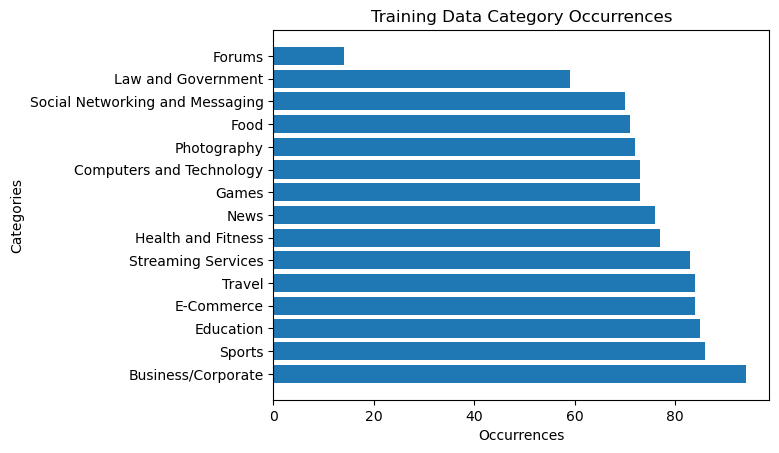

In [30]:
# Category occurrence analysis.
cat_occurrences_hist(train)

__Discussion__

Observing textual word occurrences was much more challenging.  The textual word occurrences, as we can see in the first __histogram__ are numerous.  I couldn't make sense out of plotting all of them, so instead lets look at some collapsed __histograms__.  By outputting the top 10 most used words, we can see that most of these words are basically useless when it comes to actually determining which type of category the text documents are associated with.  Most of these words are likely to be dropped during our redundant word elimination process.  However, if we take a look at most frequently used words 400 through 450, some should catch our eye.  As an example, the word 'fitness' ought to be used far more frequently in sports documents that government documents and vice versa for the word 'phone'.  This conclusion is important, as it will allow us to greatly consolidate the amount of data we're using by eliminating high frequency words that do not tell us anything about the information we need, while keeping low frequency words that are highly valuable in the categorization process.

Total number of individual word counts: 48677


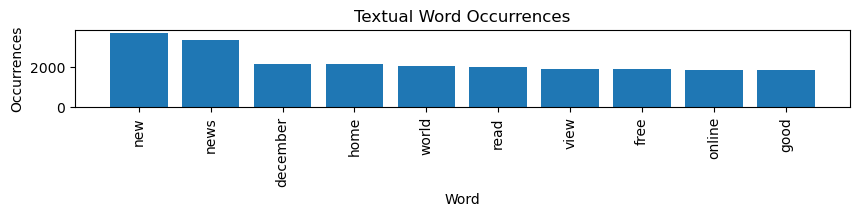

Total number of individual word counts: 48677


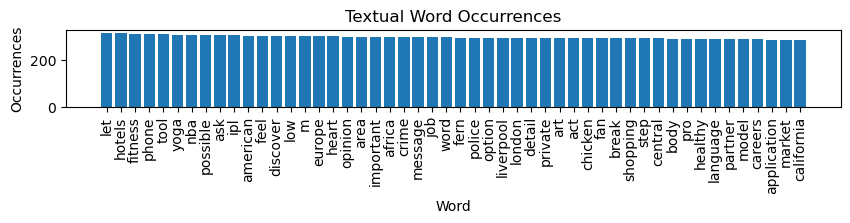

In [31]:
# Text occurrence analysis.
text_occurrences_hist(train,0,10,100000)
text_occurrences_hist(train,400,450,100000)

__Discussion__

To press the point, we can see below that the word fitness is used x14 as many times as the word phone within the Sports category, while the word fitness is only used about 1/3 as many times as the word phone in the Law and Government category

In [32]:
# Categorical word frequency analysis.
word_freq_in_cat('Sports','fitness')
word_freq_in_cat('Sports','phone')

word_freq_in_cat('Law and Government','fitness')
word_freq_in_cat('Law and Government','phone')

The occurrences of word fitness in Sports category text is: 55
The occurrences of word phone in Sports category text is: 3
The occurrences of word fitness in Law and Government category text is: 4
The occurrences of word phone in Law and Government category text is: 9


__Discussion__

Next, lets check to see if we have any text documents that have no length and see if most documents reside among similar numbers of word counts.  After plotting a histogram of the word counts, we can see that there aren't any with no word counts and they are all centered around the 400 word count region. There are outliers out past 1250 words, but my take is that 400 words with a median of 196 is probably sufficient for a learning algorithm to come in and begin classifying categories.

In [33]:
# Length of text documents function.
def text_length_hist(df):
    wordLists = df['cleaned_website_text'].str.split()
    textLengths = []

    for text in wordLists:
        textLengths.append(len(text))

    df1 = pd.DataFrame(data = textLengths)
    df1.columns = ['Counts']

    print('The median word count is: ' + str(df1['Counts'].median()))
    print('The minimum word count is: ' + str(df1['Counts'].min()))
    print('The maximum word count is: ' + str(df1['Counts'].max()))

    plt1 = sns.histplot(data = df1, x = "Counts")

The median word count is: 431.0
The minimum word count is: 1
The maximum word count is: 5252


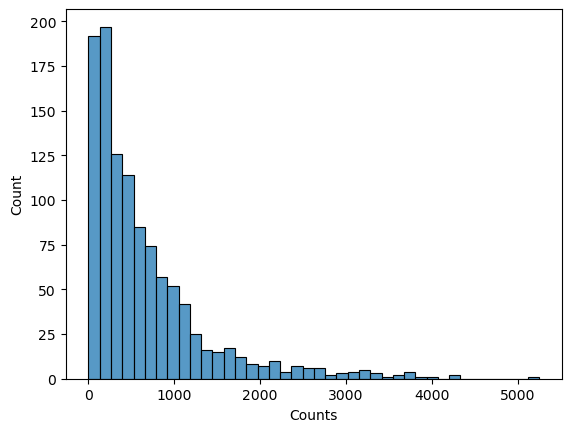

In [34]:
# Document lengths analysis.
text_length_hist(train)

__Discussion__

Now we must begin __cleaning the data__.  First, lets __remove data duplicates__.  We can find and eliminate these duplicates with pandas functions.  After outputting the duplicates, we can see that the duplicates are in fact actual textual duplicates and not just coincidences.  There appeared to be 21 total duplicates within the training data.

We will pass the text to __lower case__.  This will eliminate any ambiguity between capitalized words and lowercase words that are actually the same, but only different due to their case.  Then we will __remove the 'stop' words__ as they are referred to in the natural language tool kit.  These words are redundant and not meaningful pieces of information for our particular problem (but they certainly could be if we were putting together a more complex algorithm).

Finally, we will __remove punctuation__ and __eliminate extra spaces__.

There were 21 duplicates.
Example of duplicates: 
oil pisce fish oil health oil pisces categories fish oil health disease fish oil database add menu primary menu oil pisce fish oil health menu fish oil oilofpisces fish oil oilofpisces contain comprehensive database include hundred summary research study relate fish oil fatty acid invite browse article learn benefit risk supplement mind information contain medical advice consult doctor personal health concern scientist alert benefit fish oil early 1970 danish physician observe greenland eskimos exceptionally low incidence heart disease arthritis despite fact consume high fat diet intensive research soon discover fat oil consume large quantity epa eicosapentaenoic acid dha docosahexaenoic acid actually highly beneficial recent research establish fatty acid epa dha main component fish oil play crucial role prevention atherosclerosis heart attack depression diabetes cancer clinical trial show take supplement effective treatment disorder in

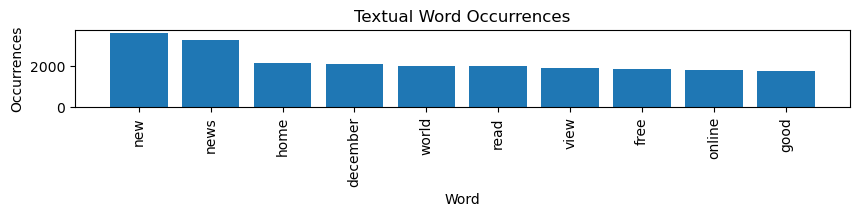

C:\Users\14436\AppData\Local\Temp\ipykernel_504\245678028.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  train['cleaned_website_text'].str.replace(r'[^\w\s]+', '')


0       page find skinny find feature search skinnyms ...
1       diario gol real madrid messi diariogol james r...
2       nmdfc skip main content update english hindi u...
3       hand foot card game rules play hand foot canas...
4       account services inc account services premier ...
                              ...                        
1122    order online pickup store lilac patisserie lil...
1123    script fix script coverage screenplay developm...
1124    certified nonwoven products certified converte...
1125    right information kids corner rti video audio ...
1126    sputnik news world news breaking news stories ...
Name: cleaned_website_text, Length: 1080, dtype: object

In [35]:
# If there are duplicates in the textual data, show an example, and then remove them.
num_dups = train.duplicated(subset=['cleaned_website_text']).sum()

if num_dups > 0:
    print('There were ' + str(num_dups) + ' duplicates.')
    dups = train[train.duplicated(subset = ['cleaned_website_text'], keep = False)]
    
    print('Example of duplicates: ')
    firstText = ''
    for text in dups['cleaned_website_text']:
        if firstText == '':
            firstText = text
        elif firstText == text:
            print(firstText)
            print('\n')
            print(text)
    train = train.drop_duplicates(subset = ['cleaned_website_text'])
else:
    print('No duplicates.')
 
    

# Send text to lowercase.
train['cleaned_website_text'].str.lower()

# Use natural language tool kit to remove stop words.
stop = nltk.corpus.stopwords.words('english')
train['cleaned_website_text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop)]))

text_occurrences_hist(train,0,10,100000)

# Remove the punctuation.
train['cleaned_website_text'].str.replace(r'[^\w\s]+', '')

# Eliminate extra spaces.
train['cleaned_website_text'].apply(lambda var: " ".join(var.split()))

__Discussion__

We can still see that there are website text lengths with just 1 word.  This is no good and we need to eliminate these redundant text documents.

The median word count is: 429.5
The minimum word count is: 1
The maximum word count is: 5252
Total number of individual word counts: 48677


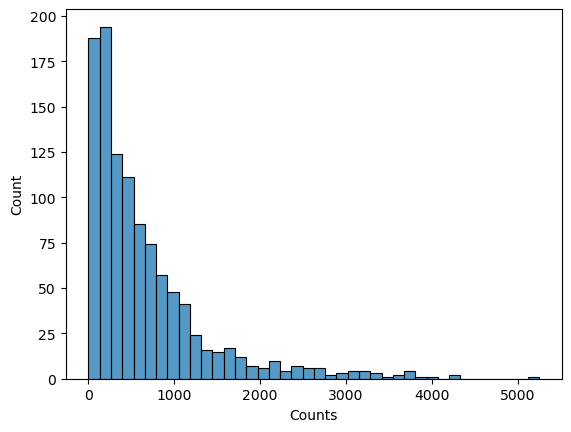

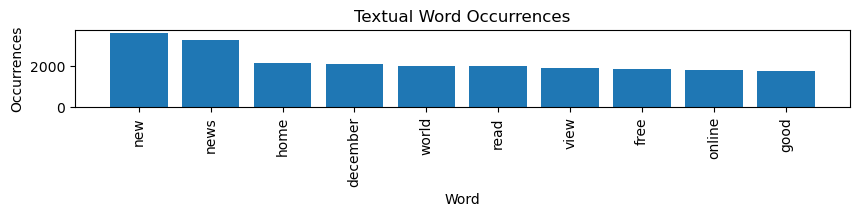

In [36]:
# Review categorical word frequencies.
text_length_hist(train)
text_occurrences_hist(train,0,10,100000)

__Discussion__

The short texts are dropped.

In [37]:
# Drop short texts.
for index, row in train.iterrows():
    if len(row['cleaned_website_text'].split()) < 10:
        train = train.drop(index)

The median word count is: 434.0
The minimum word count is: 10
The maximum word count is: 5252
Total number of individual word counts: 48674


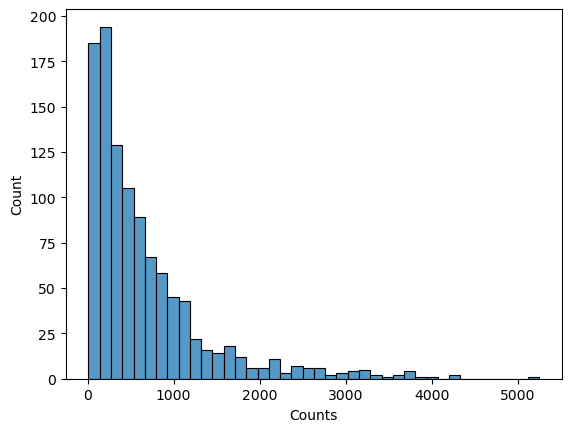

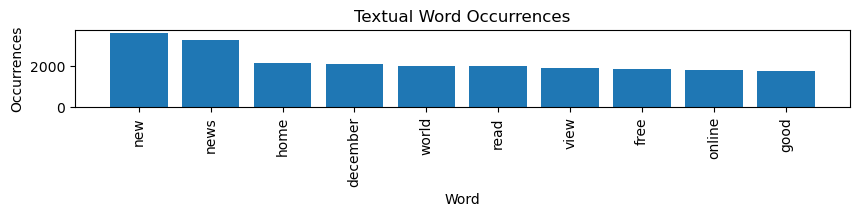

In [38]:
# Review categorical word frequencies.
text_length_hist(train)
text_occurrences_hist(train,0,10,100000)

__Discussion__

Based on the exploratory data analysis, we will explore several different unsupervised learning algorithms including __hierarchical clustering and matrix factorization__ and a supervised learning algorithm to __capture word frequencies as features__ and subsequently produce catogories for each document with which we can check against test data and the solutions data file.  In order to do this, we will first need to map words in each document to vector tokens. After some research, I concluded that the __TF-IDF mapping__ is most appropriate for this application.  In TF-IDF mapping, each word in each document is evaluated based upon its frequency of use within that document (TF) and all the documents combined (IDF).  These values are then multiplied and each word in each document is assigned a TF-IDF value.  Hierarchical clustering algorithms, matrix factorization, and supervised learning algorithms can use the TF-IDF features to produce categories.

# __Part 1.2: Unsupervised Learning Algorithms__

First, we will train a __hierarchical clustering algorithm__ using the training data from the EDA section of this report.  After finding that the __agglomerative clustering algorithm__ was incapable of handling __sparse data, dimensionality reduction__ was employed to 'densify' the data and help the algorithm to converge.  In order to perform dimensionality reduction, __principle components analysis__ was utilized, but failed to converge because it too could not handle the sparse dataset.  Instead, __truncated SVD__ was used to perform dimensionality reduction. This worked and was able to 'densify' the data for agglomerative clustering.  

Unfortunately, hierarchical clustering did not perform well (59% training accuracy).  As a result, __matrix factorization__ was explored as an alternative. After performing a __grid search__ across hyperparameters and further consolidating the data, matrix factorization produced a training accuracy of 74%.  This was good enough to move on to the next section of the report. Note that throughout the training of these algorithms, __the input features were the TF-IDF vectors__ and the __model outputs were categories.__

__Discussion__

First, we will develop several helper functions.  The dendogram plot function is directly from scipy and sklearn's website.  It plots a dendogram for a hierarchical clustering algorithm.  

The pred function performs predictions for the matrix factorization algorithm, which actually outputs probability vectors.  The pred function transforms them into actual classified categories.  

The gen_map function generates the best fit label map.  Due to the number of categories, this was challenging and may be improved upon from its current design.  Checking all permutations of the categories would mean sifting through 15! combinations, not possible.  Instead, it develops an 'agreement matrix' and picks the map from predicted outputs to actual labels based on the highest score for each predicted output value.  As a result, there may be more than one category mapped to a given predicted output.  The gen map function is algorithm agnostic, but is bound to the number of input categories and predicted types.

The accuracy function simply computes the accuracy of predictions against actual labeled categories.

The confusion matrix function takes labeled data and true data and plots a confusion matrix against the two data sets.

In [77]:
# Dendogram function for hierarchical clustering algorithm. (Mostly lifted from scipy website listed in references.)
def plot_dendrogram(m, **kwargs):
    c = np.zeros(m.children_.shape[0])
    s = len(m.labels_)
    
    for i, merge in enumerate(m.children_):
        cc = 0
        for idx in merge:
            if idx < s:
                cc += 1  # leaf node
            else:
                cc += c[idx - s]
        c[i] = cc

    lm = np.column_stack([m.children_, m.distances_, c]).astype(float)
    dendrogram(lm,no_labels = 1, above_threshold_color='c',**kwargs)
    
    plt.ylabel('Distance')
    plt.xlabel('Labels (not shown)')
    plt.title('Dendogram of Hierarchical Clustering')
    plt.show()

# Prediction function for matrix factorization and tfidf vectorizer.
def pred(matFact,tfidfVectorizer,data):
    
    # Get probability vector outputs.
    probVec = matFact.transform(tfidfVectorizer.transform(data))
    
    # Find max probabilities and generate predicted vector.
    pred = []

    for probs in probVec:
        maxProb = 0
        val = 0

        for it in range(len(probs)):
            if probs[it] > maxProb:
                val = it
                maxProb = probs[it]
        pred.append(val)
        
    return pred

# Generate label map function.  Agnostic to learning model.
def gen_map(data,preds,categories,categoriesBack): 

    cats = list(categories.keys())
    labelMap = dict()
    
    for key in range(len(categories.keys())):
        agreeVec = np.zeros(len(cats))
        ind1 = 0
        for index,row in data.iterrows():
            if key == preds[ind1]:
                agreeVec[categoriesBack[row['Category']]] += 1
                
            ind1 += 1

        ind = 0
        finalInd = 0
        maxNum = 0

        for num in agreeVec:
            if maxNum < num:
                maxNum = num
                finalInd = ind
            ind += 1
            
        labelMap[key] = categories[finalInd]

    return labelMap

# Accuracy function. Agnostic to learning model.
def acc(preds,data,labelMap,categories):
    ind1 = 0
    right = 0
    newDict = dict()
    
    for index,row in data.iterrows():
        if labelMap[preds[ind1]] == row['Category']:
            right += 1
        ind1 += 1
    
    return right/ind1

# Confusion matrix function.
def cfmat(data,labelMap,preds,categories):
    
    truth = []
    pred = []
    
    for index,row in data.iterrows():

        truth.append(row['Category'])
        
    for val in preds:
        pred.append(labelMap[val])
    
    lm = []
    
    for lab in labelMap.values():
        lm.append(lab)
        
    plt.figure(figsize=(20,12))
    confusion = confusion_matrix(truth,pred,labels = lm)
    sns.heatmap(confusion, fmt=".1f",annot=True,cmap='Reds',xticklabels=lm, yticklabels=lm)
    
    plt.title('Train Data Confusion matrix')
    plt.ylabel('Real Categories')
    plt.xlabel('Estimated Categories')
    plt.show()

__Discussion__

The first implementation of __hierarchical clustering__ failed due to the data set being __sparse.__  The agglomerative clustering algorithm requires a data set that is not sparse.

In [40]:
# Try go create hierarchical clustering model. Fails due to sparse data.
#tfidfClust = TfidfVectorizer().fit(train['cleaned_website_text'])
#vect = tfidfClust.transform(train['cleaned_website_text'])
#clustering = AgglomerativeClustering().fit(vect)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

__Discussion__

The second implementation of hierarchical clustering failed due to __principle component analysis__ not being able to handle the sparse data set.  I had attempted __dimensionality reduction__ to try to 'densify' the data for the agglomerative clustering algorithm.  

In [41]:
# Try to perform dimensionality reduction with PCA (densify the data).
# Does not work because of sparsity of data.
#tfidfClust = TfidfVectorizer().fit(train['cleaned_website_text'])
#vect = tfidfClust.transform(train['cleaned_website_text'])
#reducedvect = PCA(n_components = 100).fit_transform(vect)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

__Discussion__

The third attempt worked.  Passing the dataset to the __Truncated SVD__ algorithm enabled __dimensionality reduction__ to occur, thereby allowing the __agglomerative clustering__ algorithm to converge.

In [78]:
# Perform dimensionality reduction with TruncatedSVD and pass 'densified' data
# to hierarchical clustering algorithm.
tfidfClust = TfidfVectorizer().fit(train['cleaned_website_text'])
vect = tfidfClust.transform(train['cleaned_website_text'])
reducedvect = TruncatedSVD(n_components = 20,n_iter = 100).fit_transform(vect)

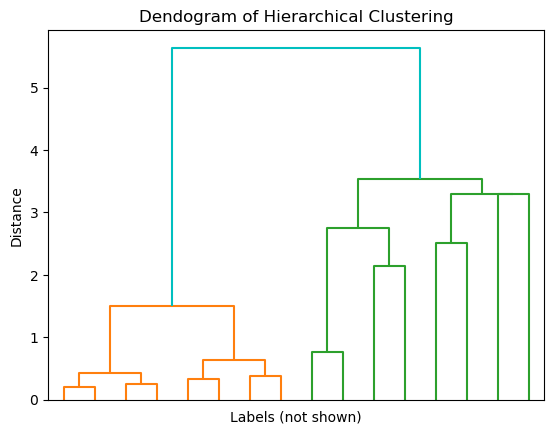

In [79]:
# Generate model for dendogram.
clusteringForDend = AgglomerativeClustering(distance_threshold = 1,n_clusters = None).fit(reducedvect)
plot_dendrogram(clusteringForDend, truncate_mode="level", p=3)

In [44]:
# Generate model predictions.  Compute accuracy.
preds = AgglomerativeClustering(n_clusters = 15).fit_predict(reducedvect)
labelMap = gen_map(train,preds,categories,categoriesBack)
train_accuracy = acc(preds,train,labelMap,categories)
print('Hierarchical clustering train accuracy: ' + str(train_accuracy))

Hierarchical clustering train accuracy: 0.6102803738317757


__Discussion__

Due to the agglomerative clustering's training accuracy being around 60% consistently, __matrix factorization__ was also explored as a potential unsupervised learning algorithm candidate.

In [45]:
# Matrix Factorization.

# Build non-negative matrix factorization model from scikit learn.
matrixFactorization = NMF(n_components=len(categories.keys()))

# Fit model on train data.
# Use TF-IDF vectorizer from sklearn to generate word frequency weights.  TF is the frequency of a word in the document.
# IDF is a measure of how rare a word is in all documents (inverse total frequency).
# TF-IDF is the product of both for a given word in a given document.
tfidfMf = TfidfVectorizer().fit(train['cleaned_website_text'])
matrixFactorization.fit(tfidfMf.transform(train['cleaned_website_text']))

C:\Users\14436\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=15)

__Discussion__

We will now take a look at what our vanilla matrix factorization algorithm produces in terms of accuracy against the training data.  It appears the vanilla matrix factorization algorithm produces around an 74.4% accuracy.

In [46]:
# Make predictions.
preds = pred(matrixFactorization,tfidfMf,train['cleaned_website_text'])

In [47]:
# Obtain label map.
labelMap = gen_map(train,preds,categories,categoriesBack)
print('Best label map:')
print(labelMap)

Best label map:
{0: 'News', 1: 'Social Networking and Messaging', 2: 'Sports', 3: 'Streaming Services', 4: 'Food', 5: 'Photography', 6: 'E-Commerce', 7: 'Streaming Services', 8: 'Games', 9: 'Travel', 10: 'Games', 11: 'Education', 12: 'Health and Fitness', 13: 'Law and Government', 14: 'Health and Fitness'}


In [48]:
# Obtain training accuracy.
train_accuracy = acc(preds,train,labelMap,categories)
print('Matrix factorization initial train accuracy: ' + str(train_accuracy))

Matrix factorization initial train accuracy: 0.7551401869158878


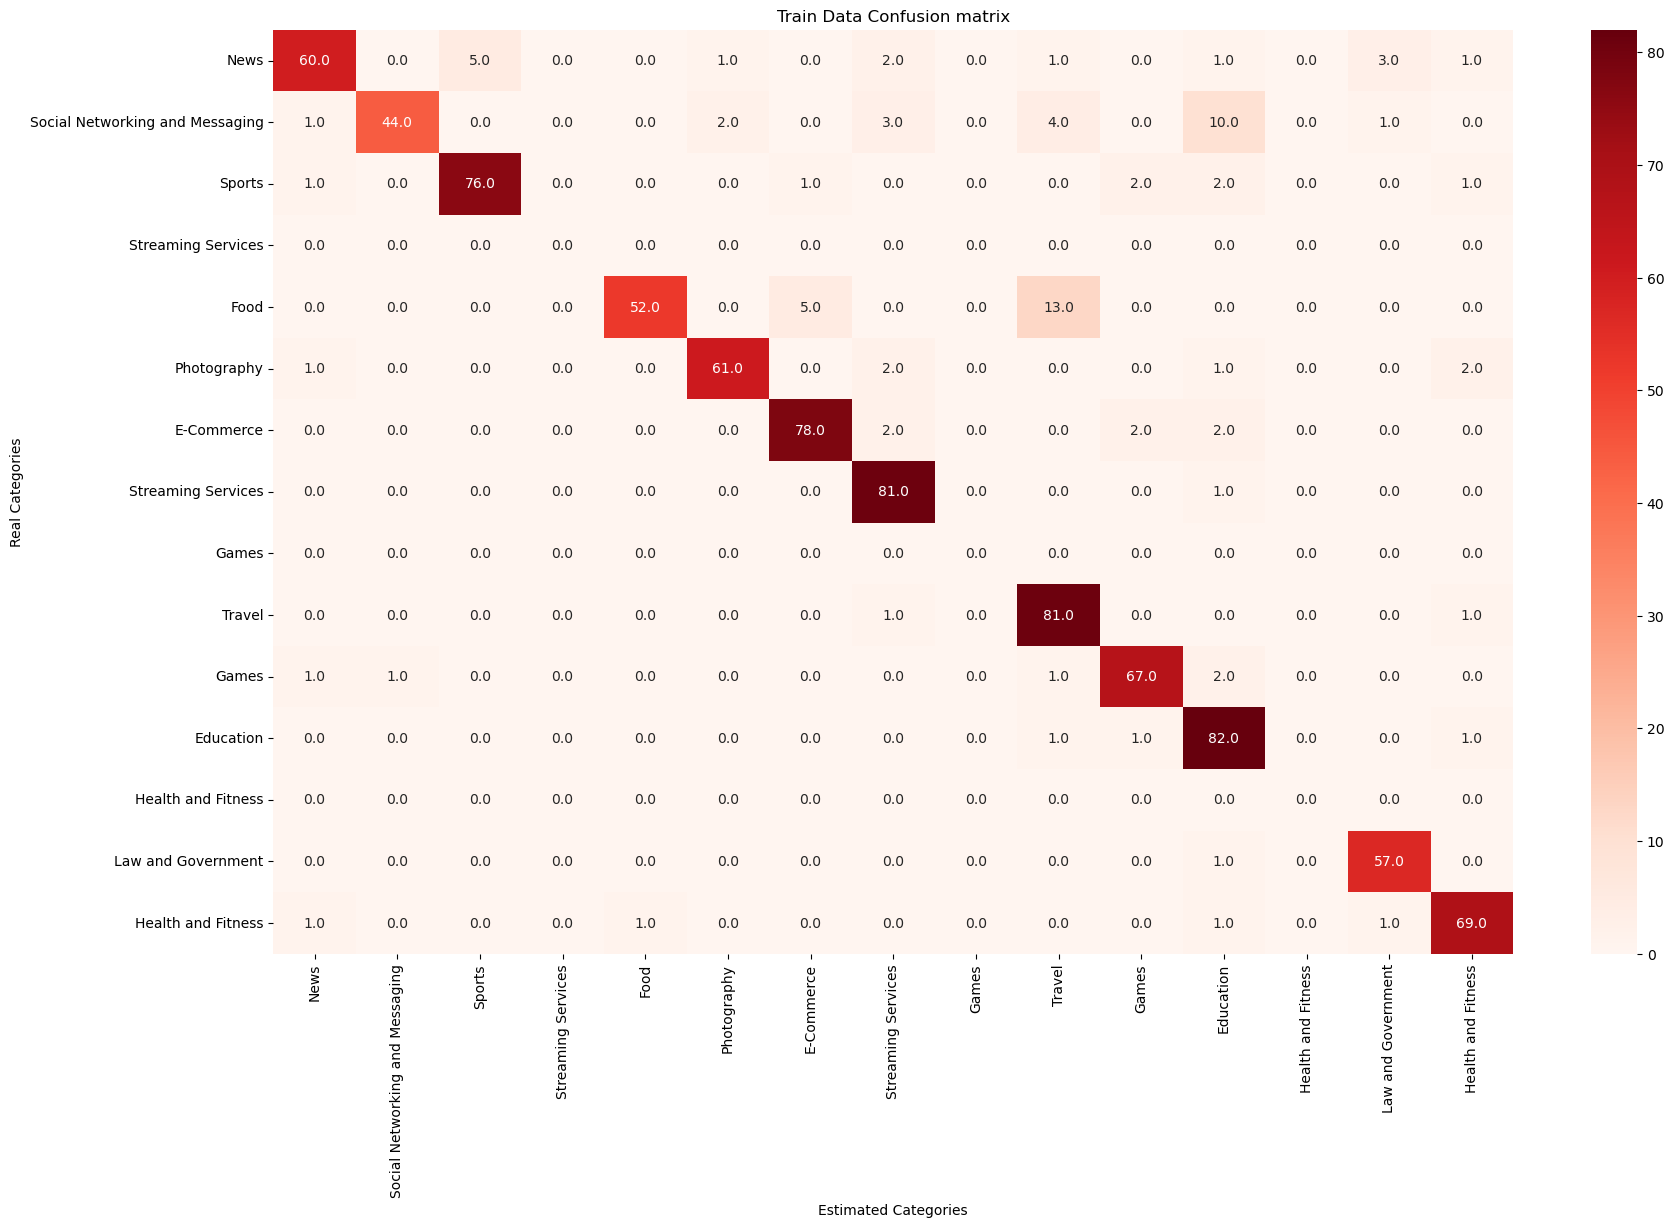

In [49]:
# Output confusion matrix.  (Some categories may be doubled.)
cfmat(train,labelMap,preds,categories)

__Discussion__

In order to try to improve the matrix factorization algorithm, I wanted to take another look at words that were retained in the dataset after the data cleaning phase of the report.  It seemed like there were a number of candidate words that I could remove manually in an effort to try to feed the matrix factorization algorithm more relevant data.  In any case, it would at least reduce the amount of data it had to process for the grid search later on.

Total number of individual word counts: 48674


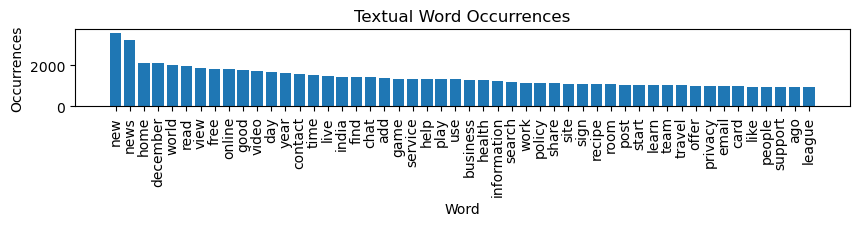

Total number of individual word counts: 48674


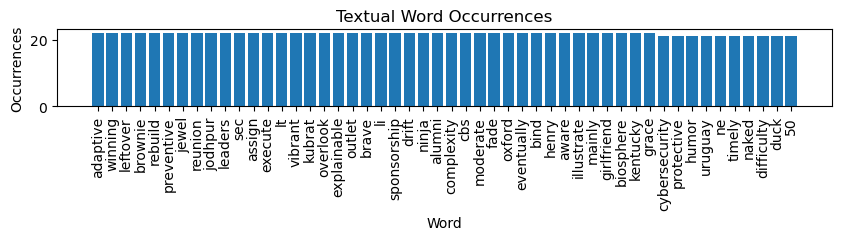

In [50]:
# Word frequency analysis.
text_occurrences_hist(train,0,50,700000)
text_occurrences_hist(train,5000,5050,700000)

In [51]:
# Remove additional redundant words.
train_reduced = train.copy()

stop2 = ['actually','etc','this','change','help','find','says','luck','able','that','made','every','believe','probably',
         'ive','trying','last','n','start','though','must','done','maybe','away','else',
         'looking','better','dont','right','you','answer','hard','using','1','called','let','said','bad','getting',
         'different','please','say','3','ever','since','them','thats','great','little','come','look','give','try','new',
         'tell','question','thats','use','lot','keep','put','without','me','sure','day','best','even','us','cant','back',
         'always','used','long','anything','around','another','got','thing','may','u','take','many','well','two','still',
         'ask','might','like','get','would','know','one','want','people','think','need','good','time','go','make','it',
         'really','could','much','something','first','also','im','way','see','2','never','things','going']
train_reduced['cleaned_website_text'] = train_reduced['cleaned_website_text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop2)]))

Total number of individual word counts: 48600


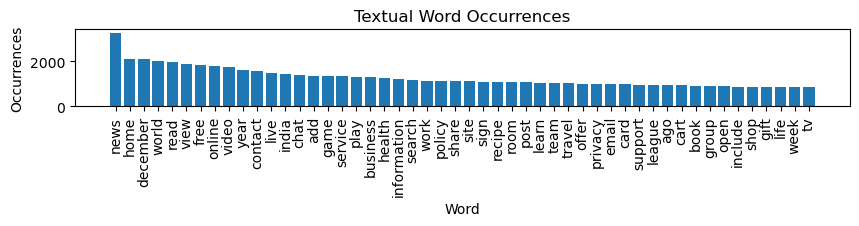

In [52]:
text_occurrences_hist(train_reduced,0,50,700000)

__Discussion__

After reducing the training set, matrix factorization improved a bit with now a 75.3% training accuracy.

In [58]:
# New matrix factorization function. Attempt to improve performace without redundant words.
matrixFactorization = NMF(n_components=len(categories.keys()))
tfidfMf = TfidfVectorizer(min_df = 1).fit(train_reduced['cleaned_website_text'])
matrixFactorization.fit(tfidfMf.transform(train_reduced['cleaned_website_text']))

C:\Users\14436\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=15)

In [59]:
# Make predictions.
preds = pred(matrixFactorization,tfidfMf,train_reduced['cleaned_website_text'])

In [60]:
# Obtain label map.
labelMap = gen_map(train_reduced,preds,categories,categoriesBack)
print('Best label map:')
print(labelMap)

Best label map:
{0: 'News', 1: 'Social Networking and Messaging', 2: 'Sports', 3: 'Streaming Services', 4: 'Food', 5: 'Photography', 6: 'E-Commerce', 7: 'Streaming Services', 8: 'Games', 9: 'Travel', 10: 'Games', 11: 'Law and Government', 12: 'Health and Fitness', 13: 'Education', 14: 'Health and Fitness'}


In [61]:
# Obtain training accuracy.
train_accuracy = acc(preds,train_reduced,labelMap,categories)
print('Matrix factorization train accuracy: ' + str(train_accuracy))

Matrix factorization train accuracy: 0.7532710280373832


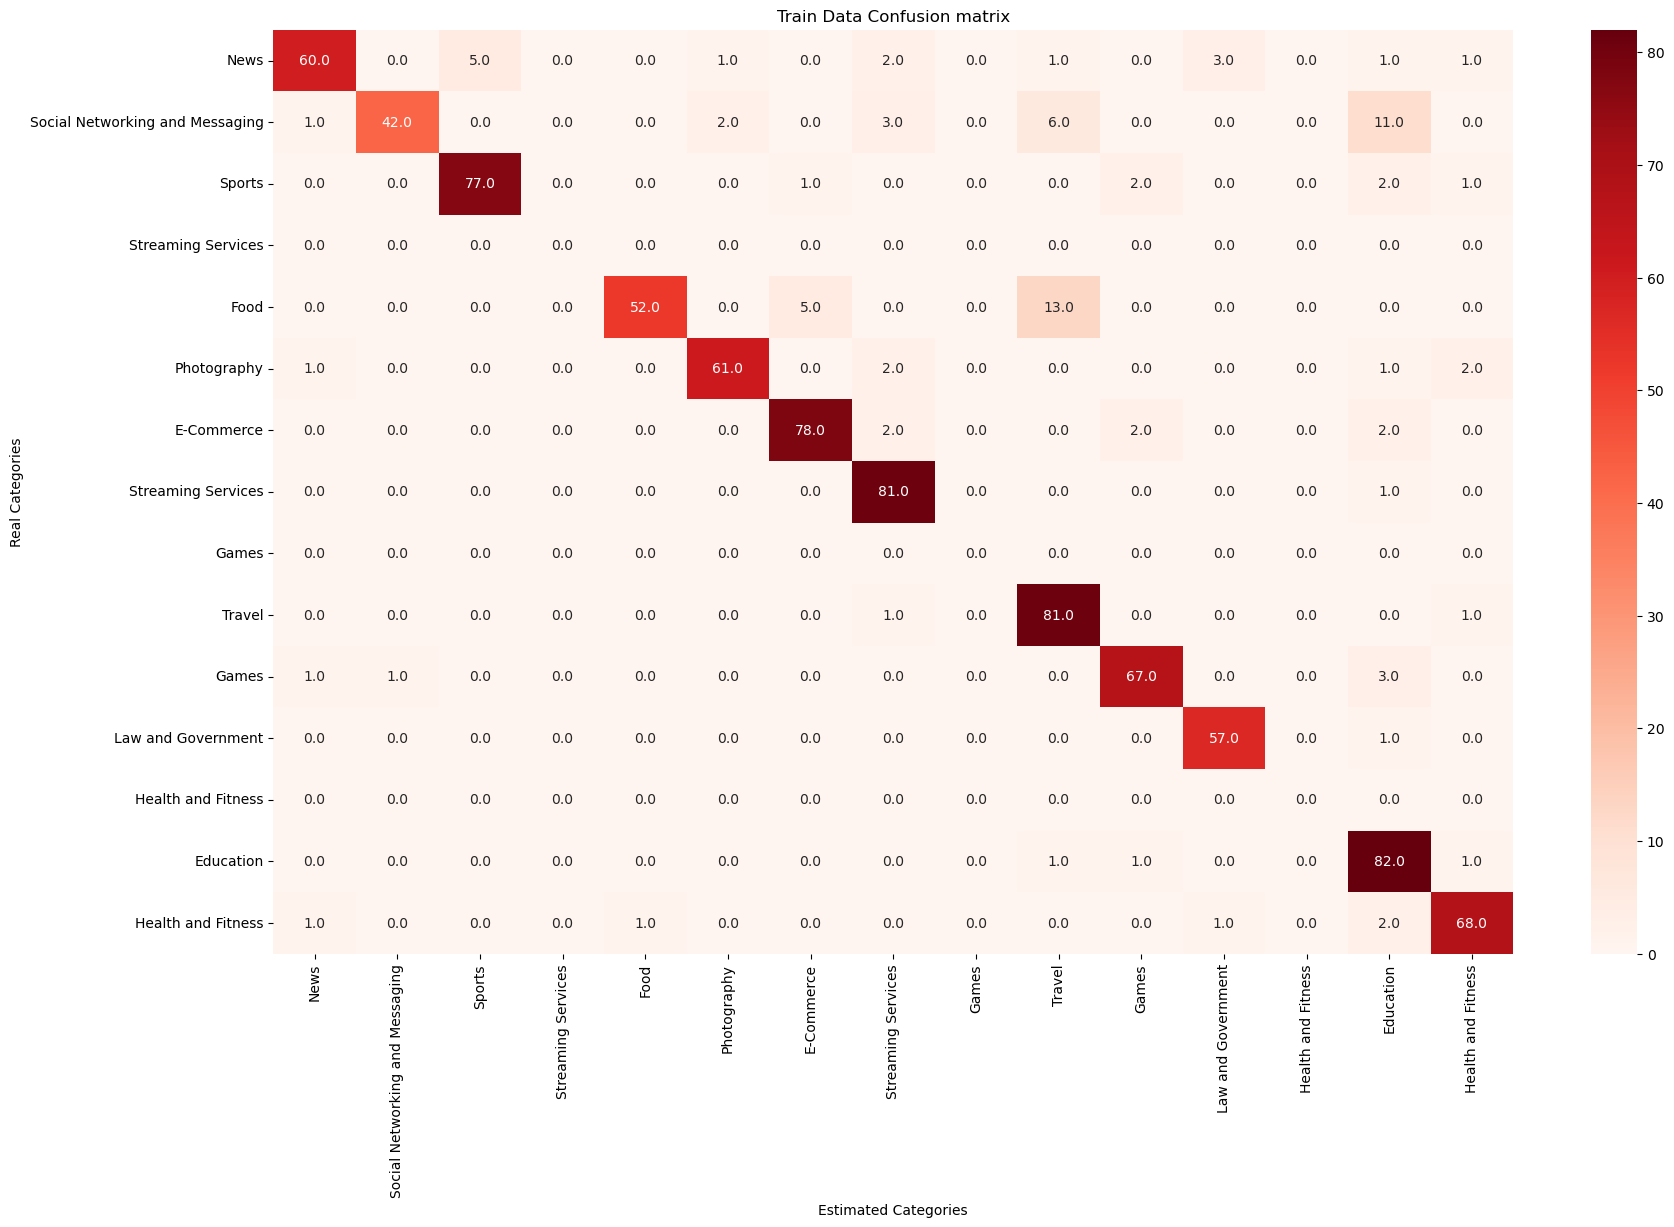

In [62]:
# Plot confusion matrix.
cfmat(train_reduced,labelMap,preds,categories)

__Discussion__

After reducing the training data set's size, I chose to perform __two grid searches__ in series.  First, I performed a grid search across tfidfVectorizer's and the matrix factorization algorithm's __hyperparameters.__  Then I performed a grid search across the tfidfvectorizer's minimum and maximum __word frequencies.__ I wanted to see if eliminating more infrequent or more highly frequent words would help the algorithm focus on important differentiating information.

Eventually, I found that frobenius for beta loss, mu for solver, and nndsvdar for initialization were the best combinations of hyperparameters for the matrix factorization algorithm. In addition, I found the l2 norm was best for the vectorizer.

Unfortunately, the minimum and maximum word frequencies did not appear to make much of a difference and sometimes sporadically injected noise into the algorithms' performance.  As a result, I found that their default values of 1 and 1.0, respectively were suitable.


In [356]:
# Grid search 1.

# Identify hyperparameters.
beta = ['frobenius','kullback-leibler']
solver = ['cd','mu']
init = ['random','nndsvd', 'nndsvda', 'nndsvdar']
norm = ['l1','l2']
out = []

for b in beta:
    for s in solver:

        # Omit certain pairs.
        if s == 'cd' and b == 'kullback-leibler':
                    continue

        for i in init:
            for n in norm:
                # Pass hyperparameters and retrain.
                matrixFactorization = NMF(n_components = len(categories.keys()),beta_loss = b, solver = s, init = i)
                tfidfMf = TfidfVectorizer(norm = n).fit(train_reduced['cleaned_website_text'])
                matrixFactorization.fit(tfidfMf.transform(train_reduced['cleaned_website_text']))

                # Evaluate new model.
                preds = pred(matrixFactorization,tfidfMf,train_reduced['cleaned_website_text'])
                labelMap = gen_map(train_reduced,preds,categories,categoriesBack)
                train_accuracy = acc(preds,train_reduced,labelMap,categories)
                out.append([b,s,i,n,maxdf,mindf,train_accuracy])
                
# Output table.
print(tabulate(out,headers = ['beta_loss','solver','init','vectorizer norm','max_df','min_df','accuracy']))

C:\Users\14436\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1411: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\14436\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1411: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\14436\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1411: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\14436\anaconda3\lib

beta_loss         solver    init      vectorizer norm      max_df    min_df    accuracy
----------------  --------  --------  -----------------  --------  --------  ----------
frobenius         cd        random    l1                        1         5    0.30863
frobenius         cd        random    l2                        1         5    0.731707
frobenius         cd        nndsvd    l1                        1         5    0.32833
frobenius         cd        nndsvd    l2                        1         5    0.749531
frobenius         cd        nndsvda   l1                        1         5    0.363977
frobenius         cd        nndsvda   l2                        1         5    0.749531
frobenius         cd        nndsvdar  l1                        1         5    0.363039
frobenius         cd        nndsvdar  l2                        1         5    0.749531
frobenius         mu        random    l1                        1         5    0.30863
frobenius         mu        random 

In [357]:
# Grid search 2.

# Identify hyperparameters.
beta = ['frobenius']
solver = ['mu']
init = ['nndsvdar']
norm = ['l2']
out = []

maxdfs = [0.94,0.95,0.96,0.97,0.98,0.99,1.0]
mindfs = [1,2,3,4,5]
for mindf in mindfs:
    for maxdf in maxdfs:
        for b in beta:
            for s in solver:

                # Omit certain pairs.
                if s == 'cd' and b == 'kullback-leibler':
                            continue

                for i in init:
                    for n in norm:
                        # Pass hyperparameters and retrain.
                        matrixFactorization = NMF(n_components = len(categories.keys()),beta_loss = b, solver = s, init = i)
                        tfidfMf = TfidfVectorizer(max_df = maxdf,min_df = mindf,norm = n).fit(train_reduced['cleaned_website_text'])
                        matrixFactorization.fit(tfidfMf.transform(train_reduced['cleaned_website_text']))

                        # Evaluate new model.
                        preds = pred(matrixFactorization,tfidfMf,train_reduced['cleaned_website_text'])
                        labelMap = gen_map(train_reduced,preds,categories,categoriesBack)
                        train_accuracy = acc(preds,train_reduced,labelMap,categories)
                        out.append([b,s,i,n,maxdf,mindf,train_accuracy])
                        
# Output table.
print(tabulate(out,headers = ['beta_loss','solver','init','vectorizer norm','max_df','min_df','accuracy']))

beta_loss    solver    init      vectorizer norm      max_df    min_df    accuracy
-----------  --------  --------  -----------------  --------  --------  ----------
frobenius    mu        nndsvdar  l2                     0.94         1    0.750469
frobenius    mu        nndsvdar  l2                     0.95         1    0.753283
frobenius    mu        nndsvdar  l2                     0.96         1    0.697936
frobenius    mu        nndsvdar  l2                     0.97         1    0.751407
frobenius    mu        nndsvdar  l2                     0.98         1    0.752345
frobenius    mu        nndsvdar  l2                     0.99         1    0.752345
frobenius    mu        nndsvdar  l2                     1            1    0.752345
frobenius    mu        nndsvdar  l2                     0.94         2    0.701689
frobenius    mu        nndsvdar  l2                     0.95         2    0.696998
frobenius    mu        nndsvdar  l2                     0.96         2    0.696998
frob

__Discussion__

Ultimately, in combination the grid searching and training data reduction boosted the matrix factorization algorithm's __training performance to 75.4%__ and its __test accuracy to 78.9%.__  These were interesting results and made me wonder if the train set included some outliers that handicapped the algorithm during the training phase.  It would also be interesting to determine which step in developing the algorithm actually made it so generalizable. In any case, these were very promising results for the next step in the report which was to pipeline the unsupervised learning algorithm's generated labels with a supervised learning algorithm's training routine.

In [64]:
# Pass hyperparameters and retrain.
matrixFactorization = NMF(n_components = len(categories.keys()),beta_loss = 'frobenius', solver = 'mu', init = 'nndsvdar')
tfidfMf = TfidfVectorizer(norm = 'l2').fit(train_reduced['cleaned_website_text'])
matrixFactorization.fit(tfidfMf.transform(train_reduced['cleaned_website_text']))

# Evaluate new model.
preds = pred(matrixFactorization,tfidfMf,train_reduced['cleaned_website_text'])
labelMap = gen_map(train_reduced,preds,categories,categoriesBack)
train_accuracy = acc(preds,train_reduced,labelMap,categories)
print('Matrix Factorization train accuracy: ' + str(train_accuracy))

Matrix Factorization train accuracy: 0.7542056074766356


In [66]:
# Pass hyperparameters and retrain.
matrixFactorization = NMF(n_components = len(categories.keys()),beta_loss = 'frobenius', solver = 'mu', init = 'nndsvdar')
tfidfMf = TfidfVectorizer(norm = 'l2').fit(train_reduced['cleaned_website_text'])
matrixFactorization.fit(tfidfMf.transform(train_reduced['cleaned_website_text']))

# Evaluate new model.
preds = pred(matrixFactorization,tfidfMf,test['cleaned_website_text'])
labelMap = gen_map(test,preds,categories,categoriesBack)
test_accuracy = acc(preds,test,labelMap,categories)
print('Matrix Factorization test accuracy: ' + str(test_accuracy))

Matrix Factorization test accuracy: 0.7890909090909091


# __Part 1.3: Unsupervised - Supervised Pipeline__

After training the unsupervised learning algorithm, I thought it would be interesting to see if we could produce data with generated labels and supplement this data with actual labeled data for a supevised machine learning's training process.

In the workplace, __high quality labeled data is the most expensive__ type of data.  Scraping the internet is inexpensive, but having, potentially, experts reviewing the data and __labeling it is time consuming__ and probably a rather lethargic use of time.  It is an interesting application to take some set of labeled training data, train an unsupervised learning algorithm to categorize the data using a small data set.  Then take more scraped unlabeled data and use the unsupervised learning algorithm to __build an augmented training set, thereby doubling, tripling, or maybe even quadrupling the labeling rate__ of human labelers.  

Of course the downside is that the unsupervised algorithm will incur some __loss in terms of accuracy.__  I would expect a need for an unsupervised learning algorithm to need a test accuracy of over 90% to make this type of activity worth it, but for the sake of this report 78.9% is probably sufficient.  It should be noted that human labelers also have some accuracy in their labeling activities that also has to be considered when looking at the full scope of such a pipeline.  Furthermore, there are __some applications that may not be so sensitive to such a high accuracy rate.__

In order to try this out, first I trained the matrix factorization algorithm off of 1/4 of a training data set, then 1/2 the train data set.  The matrix factorization algorithm's accuracy was not heavily reduced by the reduced training data sets.  I chose to go with __1/2 half the data set for the supervised learning algorithm__ just to ensure the experiment would follow through without any convergence issues. 



__Discussion__

Tested matrix factorization's global training data accuracy after just using 1/4 and then 1/2 of the training data set to train it.  It performed well only losing maybe 1-2% accuracy with 1/4 of the training data.

In [67]:
# 1/4 Train data with matrix factorization.

# Reset the reduced training datset's indices.
train_reduced.reset_index(inplace = True)

# Create data subset.
subset = train_reduced[0:len(train_reduced['cleaned_website_text'])//4]
print('Length reduced training set: ' + str(len(train_reduced['cleaned_website_text'])))
print('Length subset: ' + str(len(subset['cleaned_website_text'])))
subset.head()

# Pass hyperparameters and retrain.
matrixFactorization = NMF(n_components = len(categories.keys()),beta_loss = 'frobenius', solver = 'mu', init = 'nndsvdar')
tfidfMf = TfidfVectorizer(norm = 'l2').fit(subset['cleaned_website_text'])
matrixFactorization.fit(tfidfMf.transform(subset['cleaned_website_text']))

# Evaluate new model.
preds = pred(matrixFactorization,tfidfMf,train_reduced['cleaned_website_text'])
labelMap = gen_map(train_reduced,preds,categories,categoriesBack)
train_accuracy = acc(preds,train_reduced,labelMap,categories)

print('Accuracy across entire training dataset: ' + str(train_accuracy))

Length reduced training set: 1070
Length subset: 267
Accuracy across entire training dataset: 0.7373831775700934


In [68]:
# 1/2 Train data with matrix factorization.

# Create data subset.
subset = train_reduced[0:len(train_reduced['cleaned_website_text'])//2]
print('Length reduced training set: ' + str(len(train_reduced['cleaned_website_text'])))
print('Length subset: ' + str(len(subset['cleaned_website_text'])))
subset.head()

# Pass hyperparameters and retrain.
matrixFactorization = NMF(n_components = len(categories.keys()),beta_loss = 'frobenius', solver = 'mu', init = 'nndsvdar')
tfidfMf = TfidfVectorizer(norm = 'l2').fit(subset['cleaned_website_text'])
matrixFactorization.fit(tfidfMf.transform(subset['cleaned_website_text']))

# Evaluate new model.
preds = pred(matrixFactorization,tfidfMf,train_reduced['cleaned_website_text'])
labelMap = gen_map(train_reduced,preds,categories,categoriesBack)
train_accuracy = acc(preds,train_reduced,labelMap,categories)


print('Accuracy across entire training dataset: ' + str(train_accuracy))

Length reduced training set: 1070
Length subset: 535
Accuracy across entire training dataset: 0.7485981308411215


__Discussion__

Prepared __supervised learning training data__ set with just __1/2 labeled training data__ and __1/2 generated data__ from the matrix factorization algorithm.

In [69]:
# Pipe unsupervised categories into supervised learning algorithm for training.

# Create supervised learning training set out of 1/2 generated subset and 1/2 original training data.
trainSL = subset.copy()
subset2 = train_reduced[len(train_reduced['cleaned_website_text'])//2:]
ind = len(train_reduced['cleaned_website_text'])//2

for text in subset2['cleaned_website_text']:
    dict1 = {'index':[0],'cleaned_website_text':[text],'Category':labelMap[preds[ind]]}
    df = pd.DataFrame(dict1)
    trainSL = trainSL.append(df,ignore_index = True)
    ind += 1

C:\Users\14436\AppData\Local\Temp\ipykernel_504\129683768.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trainSL = trainSL.append(df,ignore_index = True)


__Discussion__

First, I ran the __support vector machine__ against the __full set of train data__ and found its training accuracy and test accuracy.  It got a perfect score on the training data, but dropped to 91.6% accuracy across the test data.

In [70]:
# Prepare input vectorizer.
tfidfVectorizerSL = TfidfVectorizer(norm = 'l2').fit(train_reduced['cleaned_website_text'])

# Support Vector Machine.
clf = svm.SVC()

# Grid search
grid = {'gamma': ['auto','scale'],'kernel': ['linear','poly','rbf']}
search = GridSearchCV(estimator=clf, param_grid=grid, scoring='accuracy')
search.fit(tfidfVectorizerSL.transform(train_reduced['cleaned_website_text']), train_reduced['Category'])

# Get best classifier.
best_clf = search.best_estimator_

# Output training accuracy.
slPreds = best_clf.predict(tfidfVectorizerSL.transform(train_reduced['cleaned_website_text']))
acc1 = (train_reduced['Category'] == slPreds).sum()/len(slPreds)
print('Supervised Learning Model Accuracy with only Train Data: ' + str(acc1))

# Output testing accuracy.
slPreds = best_clf.predict(tfidfVectorizerSL.transform(test['cleaned_website_text']))
acc1 = (test['Category'] == slPreds).sum()/len(slPreds)
print('Supervised Learning Model Accuracy with only Train Data: ' + str(acc1))

Supervised Learning Model Accuracy with only Train Data: 1.0
Supervised Learning Model Accuracy with only Train Data: 0.9163636363636364


__Discussion__

Next I ran the __support vector machine__ against the __1/2 generated and 1/2 labeled__ training data set.  I was happy to see its test accuracy only dropped by about 6%.  I believe given more time, the matrix factorization algorithm could be made to perform even better and close up that 6%.  Further, we can see that the gap between the full training data set SVM's train vs test accuracy is 9%, while the gap between the test and train accuracy of the SVM when trained against the 50/50 data set is only 1%.  Implying a more generalizable model, which would be the goal of data augmentation.  Very interesting results, and I believe there is an actual business application to this kind of technique.

In [72]:
# Support Vector Machine (1/2 generated data 1/2 labeled training data)
clf = svm.SVC()

# Grid search
grid = {'gamma': ['auto','scale'],'kernel': ['linear','poly','rbf']}
search = GridSearchCV(estimator=clf, param_grid=grid, scoring='accuracy')
search.fit(tfidfVectorizerSL.transform(trainSL['cleaned_website_text']), trainSL['Category'])

# Get best classifier.
best_clf = search.best_estimator_

# Output accuracy.
slPreds = best_clf.predict(tfidfVectorizerSL.transform(trainSL['cleaned_website_text']))
acc1 = (train_reduced['Category'] == slPreds).sum()/len(slPreds)
print('Supervised Learning Model Accuracy with 50% Generated Data: ' + str(acc1))

# Support Vector Machine
slPreds = best_clf.predict(tfidfVectorizerSL.transform(test['cleaned_website_text']))
acc1 = (test['Category'] == slPreds).sum()/len(slPreds)
print('Supervised Learning Model Test Accuracy: ' + str(acc1))

Supervised Learning Model Accuracy with 50% Generated Data: 0.8682242990654205
Supervised Learning Model Test Accuracy: 0.8545454545454545


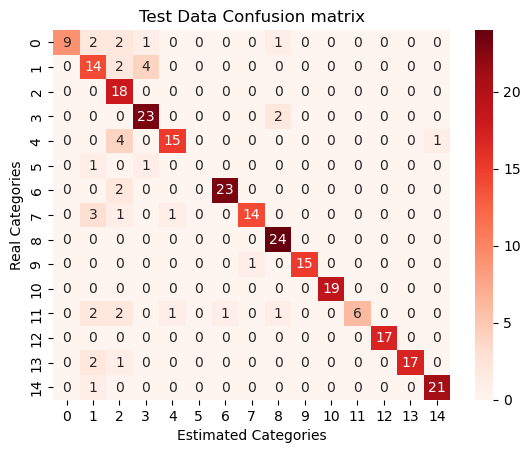

In [73]:
# Plot confusion matrix.
confusion = confusion_matrix(test['Category'],slPreds)
sns.heatmap(confusion, annot=True,cmap='Reds',xticklabels=labelMap, yticklabels=labelMap)
plt.title('Test Data Confusion matrix')
plt.ylabel('Real Categories')
plt.xlabel('Estimated Categories')
plt.show()

__References:__

1. Kaggle. Website Classification. Hetul Mehta. https://www.kaggle.com/datasets/hetulmehta/website-classification.

2. Kaggle. Matrix Factorization (97% acc with 1% labels). JIESHENDS2020. https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels.

3. Scikit Learn. sklearn.feature_extraction.text.TfidfVectorizer. scikit-learn developers. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html.

4. Scikit Learn. sklearn.decomposition.NMF. scikit-learn developers. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html.

5. NLTK. Natural Language Toolkit. NLTK Project. https://www.nltk.org/.

6. Scikit Learn. sklearn.svm.SVC. scikit-learn developers. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html.

7. Scipy v1.12.0 Manual. scipy.cluster.hierarchy.dendogram. scipy developers. https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html.

8. Scikit Learn. sklearn.cluster.AgglomerativeClustering. scikit-learn developers. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html.

9. Scikit Learn. sklearn.decomposition.PCA. scikit-learn developers. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.

10. Scikit Learn. sklearn.decomposition.TruncatedSVD. scikit-learn developers. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html.